In [1]:
import os 
import shutil
try:
    shutil.rmtree("populations")
    os.mkdir("populations")
except:
    os.mkdir("populations")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from xfoil import XFoil
from xfoil.model import Airfoil
from scipy.interpolate import CubicSpline
from scipy.special import comb
import math
from deap import base, creator, tools, algorithms
from xfoil.test import naca0012

# Define the airfoil function
n_ctr_pts = 10
angle_attack = 10
n_times = 120
max_iterations= 100
# Genetic Algorithm parameters
population_size = 100
max_generations = 150
mach = 0.15
re = 1e6
std_x = [naca0012.x[i] for i in range(0, naca0012.x.shape[0], naca0012.x.shape[0] // (n_ctr_pts * 2))][:-1] + [1]
std_y = [naca0012.y[i] for i in range(0, naca0012.x.shape[0], naca0012.x.shape[0] // (n_ctr_pts * 2))][:-1] + [0]


In [3]:
def normalize_airfoil(points):
    # Extract x-coordinates and y-coordinates
    x_coords = np.array([p[0] for p in points])
    y_coords = np.array([p[1] for p in points])
    
    # Find the leading edge (min x-coordinate) and trailing edge (max x-coordinate)
    x_min = np.min(x_coords)
    x_max = np.max(x_coords)
    
    # Calculate the chord length
    chord_length = x_max - x_min
    
    # Normalize x-coordinates to make the chord length equal to 1
    normalized_x_coords = (x_coords - x_min) / chord_length
    
    # Combine normalized x-coordinates and original y-coordinates
    normalized_points = np.array(list(zip(normalized_x_coords, y_coords)))
    
    return normalized_points
def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """
    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

def airfoil(h, n_ctr_pts=n_ctr_pts, chord=naca0012.x, nTimes=n_times):
    top_half = [(x, y) for x, y in zip(chord[:n_ctr_pts], h[0])] 
    low_half = [(x, -y) for x, y in zip(chord[n_ctr_pts:], h[1])]
    pts =  top_half +  low_half  # Include leading and trailing edges
    pts = np.array(pts)
    x = np.append(pts[:, 0][:-1], pts[:, 0][0])
    y = np.append(pts[:, 1][:-1], pts[:, 1][0])
    t = np.linspace(0.0, 1, nTimes)
    polynomial_array = np.array([ bernstein_poly(i, n_ctr_pts*2-1, t) for i in range(0, n_ctr_pts*2)   ])
    xvals = np.dot(x, polynomial_array)
    yvals = np.dot(y, polynomial_array)
    pts = np.column_stack([xvals, yvals])
    pts = normalize_airfoil(pts)
    #plot_foil(pts)
    """plt.figure(figsize=(10, 5))
    plt.scatter(x[0], y[0],  color='r', marker='o')
    plt.scatter(x[-1], y[-1])
    plt.plot(x,y)
    plt.plot(xvals, yvals)
    plt.grid(True)"""
    return pts, Airfoil(x=pts[:, 0], y=pts[:, 1])

def plot_foil(pts, fit, lift_im, drag_im, std_points=[naca0012.x, naca0012.y], save=True):
    # Extract x and y coordinates for plotting
    x, y = pts[:, 0], pts[:, 1]
    # Plot the airfoil shape
    plt.figure(figsize=(10, 4))
    plt.plot(x, y, label='Airfoil Shape', color='b', marker='o')
    plt.fill(x, y, 'b', alpha=0.3)  # Fill the shape for better visualization
    plt.plot(std_points[0], std_points[1], label='NACA0012', color='r', marker='o')
    plt.fill(std_points[0], std_points[1], 'r', alpha=0.3)
    # Adding labels and legend
    plt.xlabel('Chord Position')
    plt.ylabel('Height')
    plt.title('Airfoil Shape')
    plt.legend()
    plt.text(0.78, -0.20, f'lift improvment {lift_im:.2f}%\ndrag improvment {drag_im:.2f}%', fontsize=10)
    plt.text(0, -0.20, f'C_lift {fit[0]:.3f}, C_drag {abs(fit[1]):.3f}', fontsize=10)
    #plt.grid(True)
    plt.axis('equal')
    if save:
        plt.savefig(f"nsga\ea_lift_{lift_im:.2f}_drag_{drag_im:.2f}.pdf")
    plt.show()


In [4]:
def fitness(air):
    xf = XFoil()
    xf.airfoil = air
    xf.Re = re
    xf.mach = mach
    xf.max_iter = 100
    cl, cd, cm, cp = xf.a(angle_attack)
    return cl, cd

In [5]:
# Function to evaluate fitness (maximize Cl, minimize Cd)
def evaluate_airfoil(individual):
    # Decode individual (genotype) into airfoil parameters
    h = np.array([individual[:n_ctr_pts], np.abs(individual[n_ctr_pts:])])
    
    # Generate airfoil shape
    pts, foil = airfoil(h, n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
    
    # Use XFoil to evaluate Cl and Cd
    xf = XFoil()
    xf.airfoil = foil
    xf.Re = re
    xf.mach = mach
    xf.max_iter = max_iterations
    # Run XFoil analysis

    cl, cd, cm, cp = xf.a(angle_attack)
    if math.isnan(cl) or math.isnan(cd):
        return 0, -10e5
    else:
        # Return Cl and -Cd (minimize Cd -> maximize -Cd)
        return cl, -cd
# Function to evaluate fitness (maximize Cl, minimize Cd)


In [6]:
# Function to evaluate fitness (maximize Cl, minimize Cd)
def evaluate_airfoil_angle_attacks(foil, min=-20, max=20, step=1, max_iterations=1000):
    # Decode individual (genotype) into airfoil parameters
    
    # Generate airfoil shape
    
    # Use XFoil to evaluate Cl and Cd
    xf = XFoil()
    xf.airfoil = foil
    xf.Re = re
    xf.mach = mach
    xf.max_iter = max_iterations
    # Run XFoil analysis
    a, cl, cd, cm, cp = xf.aseq(min, max, step)

    # Return Cl and -Cd (minimize Cd -> maximize -Cd)
    return a, cl, cd


In [7]:
def naca_eval(min=-20, max=20, step=1):
    xf = XFoil()
    xf.airfoil = naca0012
    xf.Re = re
    xf.mach = mach
    xf.max_iter = max_iterations
    # Run XFoil analysis
    a, cl, cd, cm, cp = xf.aseq(min, max, step)
    return a, cl, cd

In [8]:

# Create DEAP types: FitnessMin for minimization, with 2 objectives (Cl and -Cd)
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Initialize DEAP toolbox
toolbox = base.Toolbox()

# Register individuals and population generator
toolbox.register("attr_float", np.random.uniform, 0, 0.1)  # Genes initialization
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=n_ctr_pts*2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register genetic operators
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Blend crossover
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)  # Gaussian mutation
toolbox.register("select", tools.selNSGA2)  # NSGA-II selection

toolbox.register("evaluate", evaluate_airfoil)

# Create initial population (using NACA0012 as baseline)
initial_population = []
for _ in range(population_size):
    perturbation = np.random.normal(0, 0.01, size=n_ctr_pts * 2)
    individual = np.concatenate((std_y[:n_ctr_pts], np.abs(std_y[n_ctr_pts:]))) + perturbation
    initial_population.append(individual)

# Save population function
def save_population(population, generation):
    valid_individuals = [ind for ind in population if ind.fitness.values != (0.0, -1e5)]
    with open(f'populations/population_gen_{generation}.txt', 'w') as file:
        for ind in valid_individuals:
            file.write(f"{ind} Fitness: {ind.fitness.values}\n")

# Modified eaMuPlusLambda with a callback for saving populations
def custom_eaMuPlusLambda(population, toolbox, mu, lambda_, cxpb, mutpb, ngen, stats=None,
                          halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the entire population
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = list(map(toolbox.evaluate, invalid_ind))
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = list(map(toolbox.clone, offspring))
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if np.random.random() < cxpb:
                toolbox.mate(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values

        for mutant in offspring:
            if np.random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Replace the population with the offspring
        population[:] = offspring

        if halloffame is not None:
            halloffame.update(population)

        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)
        # Save the population of the current generation
        save_population(population, gen)

    return population, logbook

# Create the initial population
pop = toolbox.population(n=population_size)

# Apply the modified DEAP algorithm
custom_eaMuPlusLambda(pop, toolbox, mu=population_size, lambda_=population_size, cxpb=0.5, mutpb=0.2, ngen=max_generations, verbose=True)



gen	nevals
0  	100   
1  	45    
2  	54    
3  	70    
4  	59    
5  	69    
6  	66    
7  	63    
8  	60    
9  	56    
10 	54    
11 	56    
12 	51    
13 	69    
14 	59    
15 	49    
16 	58    
17 	58    
18 	60    
19 	50    
20 	70    
21 	52    
22 	58    
23 	60    
24 	62    
25 	68    
26 	59    
27 	64    
28 	64    
29 	55    
30 	56    
31 	72    
32 	58    
33 	53    
34 	64    
35 	71    
36 	53    
37 	63    
38 	63    
39 	49    
40 	51    
41 	61    
42 	65    
43 	56    
44 	63    
45 	60    
46 	62    
47 	59    
48 	51    
49 	60    
50 	49    
51 	64    
52 	71    
53 	68    
54 	63    
55 	58    
56 	51    
57 	61    
58 	61    
59 	54    
60 	60    
61 	61    
62 	71    
63 	62    
64 	62    
65 	70    
66 	64    
67 	55    
68 	72    
69 	68    
70 	63    
71 	60    
72 	59    
73 	57    
74 	58    
75 	61    
76 	60    
77 	48    
78 	61    
79 	51    
80 	58    
81 	57    
82 	70    
83 	54    
84 	66    
85 	66    
86 	64    
87 	58    
88 	47    
89 	56    

([[1.1653764540189988,
   -0.0019904737787150295,
   1.9977006860564561,
   -1.0594248254337508,
   -0.29562826191770386,
   1.7288614643561675,
   -0.6980476208599005,
   -0.5850702308816758,
   0.10105487433505506,
   -0.9595809584894996,
   -10.302636294309428,
   -33.043034290796456,
   -0.46962443791229813,
   0.1530827128779948,
   -0.1381387682034952,
   -1.2305849579742254,
   -4.549242411080758,
   15.756921873158305,
   -1.610744438646115,
   0.081037732054497],
  [-10.25372182437984,
   -0.32116425272090665,
   0.41558935916530954,
   -0.45927691276524274,
   -0.13954347029833997,
   0.2722260220036625,
   -1.5244116316677174,
   -0.3759086834468805,
   0.06023021184507503,
   -0.512963267806023,
   -5.596756391342886,
   -30.087032913458295,
   -0.18539077113129104,
   0.4749736998620771,
   0.763533568081998,
   -0.7685547795008194,
   -4.444935669511149,
   8.56807647773192,
   -10.59710104622578,
   0.3056208018785262],
  [-6.734877960723114,
   -0.4073424817271903,
   1

In [9]:
import os
import matplotlib.pyplot as plt

def load_population(folder="populations"):
    populations = {}
    
    for filename in os.listdir(folder):
        if filename.startswith("population_gen_") and filename.endswith(".txt"):
            gen_num = int(filename.split('_')[-1].split('.')[0])
            population = []
            
            with open(os.path.join(folder, filename), 'r') as file:
                for line in file:
                    if line.strip():
                        parts = line.strip().split('Fitness:')
                        individual_str = parts[0].strip()[1:-1]
                        fitness_str = parts[1].strip()[1:-1]
                        individual = list(map(float, individual_str.split(',')))
                        fitness = tuple(map(float, fitness_str.split(',')))
                        population.append((individual, fitness))
            
            populations[gen_num] = population
    
    return populations

def dominates(point1, point2):
    return (point1[0] >= point2[0] and point1[1] <= point2[1]) and (point1 != point2)

def pareto_front(points):
    pareto_points = []
    for i, point1 in enumerate(points):
        is_dominated = False
        for j, point2 in enumerate(points):
            if i != j and dominates(point2, point1):
                is_dominated = True
                break
        if not is_dominated:
            pareto_points.append(point1)
    return pareto_points

# Load populations from the folder
populations = load_population()

lifts = []
drags = []
for gen, population in populations.items():
    for ind, fit in population:
        if fit[0] != 0 and fit[1] != -1e5:
            if -fit[1]<0.25:
                lifts.append(fit[0])
                drags.append(-fit[1])

# Combine the lists into a list of points
points = list(zip(lifts, drags))

# Find the Pareto front
pareto = pareto_front(points)

# Separate the Pareto front points
pareto_l = [p[0] for p in pareto]
pareto_d = [p[1] for p in pareto]

# Remove Pareto front points from lifts and drags
remaining_points = [p for p in points if p not in pareto]
remaining_l = [p[0] for p in remaining_points]
remaining_d = [p[1] for p in remaining_points]
# Get fitness for NACA0012
naca0012_fit = np.array(fitness(naca0012))


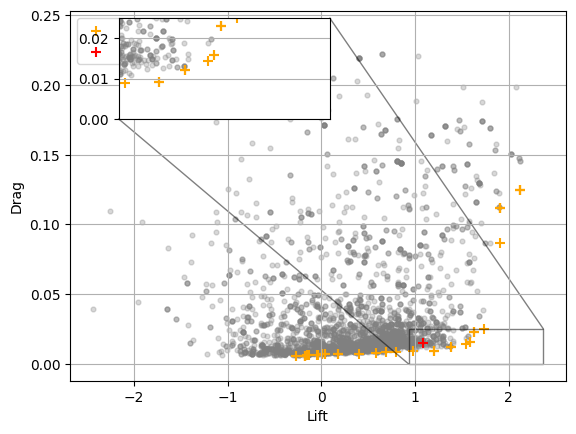

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch


# Create the main plot
fig, ax = plt.subplots()
ax.scatter(remaining_l, remaining_d, color="grey", s=12, alpha=0.3)
ax.scatter(pareto_l, pareto_d, color="orange", marker='+', s=60, label="Pareto Front")
naca0012_fit = np.array(fitness(naca0012))
ax.scatter(naca0012_fit[0], naca0012_fit[1], color="red", marker='+', s=60, label="NACA0012")
# Define the zoomed area (replace with1 your specific coordinates)
zoom_x1, zoom_x2 = naca0012_fit[0] -0.15, max(lifts) + 0.25
zoom_y1, zoom_y2 = 0, naca0012_fit[1] + 0.01

# Add a rectangle to highlight the zoomed area
rect = plt.Rectangle((zoom_x1, zoom_y1), zoom_x2 - zoom_x1, zoom_y2 - zoom_y1, 
                     edgecolor='black', facecolor='none', linestyle='-', alpha=0.5)
ax.add_patch(rect)

# Create an inset plot
axins = inset_axes(ax, width="30%", height="30%", loc='upper left', bbox_to_anchor=(0.19, 0.18, 1.1, .7),
                   bbox_transform=ax.figure.transFigure)

# Plot the same data on the inset
axins.scatter(remaining_l, remaining_d, color="grey", s=12, alpha=0.3)
axins.scatter(pareto_l, pareto_d, color="orange", marker='+', s=60)

# Set the limits of the inset plot to match the zoomed area
axins.set_xlim(zoom_x1, zoom_x2)
axins.set_ylim(zoom_y1, zoom_y2)
axins.grid(True)

# Hide x-axis labels of the inset plot to avoid overlapping
axins.xaxis.set_visible(False)

# Add lines connecting the rectangle to the inset plot
for side in [(zoom_x1, zoom_y1),(zoom_x2, zoom_y2)]:
    con = ConnectionPatch(xyA=side, coordsA=ax.transData,
                          xyB=side, coordsB=axins.transData,
                          color='black', linestyle='-', linewidth=1, alpha = 0.5)
    ax.add_artist(con)

ax.set_xlabel("Lift")
ax.set_ylabel("Drag")
ax.legend()
ax.grid(True)

plt.savefig("nsga_pareto.pdf")
plt.show()


In [11]:
import pygmo as pg

def compute_hypervolume(lifts, drags, reference_point):
    # Combine lifts and drags into a list of points
    points = list(zip(lifts, drags))
    
    # Create a hypervolume object
    hv = pg.hypervolume(points)
    
    # Compute the hypervolume with respect to the reference point
    volume = hv.compute(reference_point)
    
    return volume
# Define a reference point that dominates all points in your list
reference_point = [2.6, 0.26]

hypervolume = compute_hypervolume(pareto_l, pareto_d, reference_point)
print(f"The hypervolume is: {hypervolume}")


The hypervolume is: 0.7295462319198261


## Pareto front results

### Elbow Point

In [12]:

pareto = np.array(pareto)
# Normalize the objectives
lift_values = np.abs(pareto[:, 0])
drag_values = np.abs(pareto[:, 1])

norm_lift = (lift_values - lift_values.min()) / (lift_values.max() - lift_values.min())
norm_drag = (drag_values - drag_values.min()) / (drag_values.max() - drag_values.min())

# Compute the distances to the ideal point (1, 0)
ideal_point = np.array([1, 0])
distances = np.sqrt((1 - norm_lift)**2 + norm_drag**2)

# Find the elbow point
elbow_index = np.argmin(distances)
elbow_point = pareto[elbow_index]

print(f"Elbow point (best trade-off): Lift = {elbow_point[0]}, Drag = {elbow_point[1]}")


Elbow point (best trade-off): Lift = 1.7361080646514893, Drag = 0.024987373501062393


#### Section 1
ploting the Airfoils that give a better drag and lift compared to the NACA0012
#### Section 2
plotting all the pareto front individuals

## Section 1

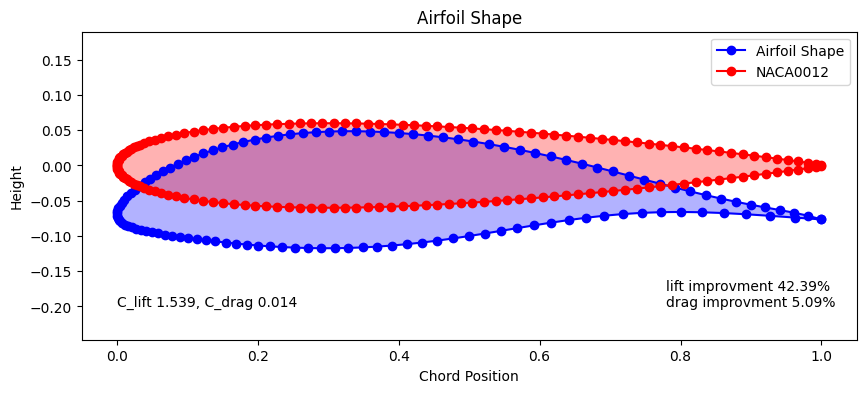

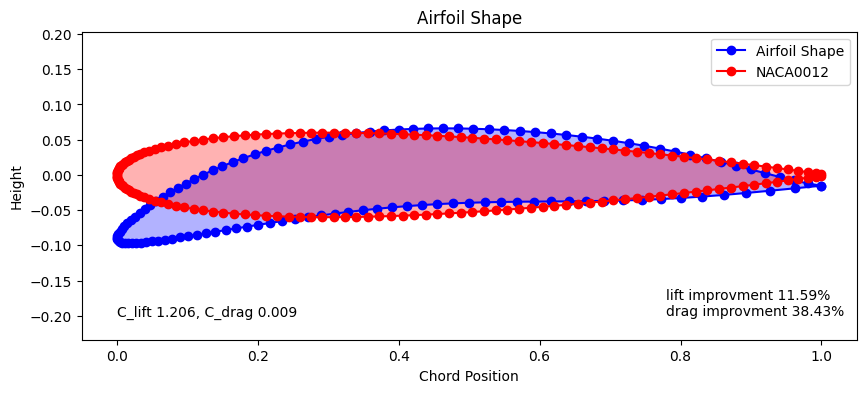

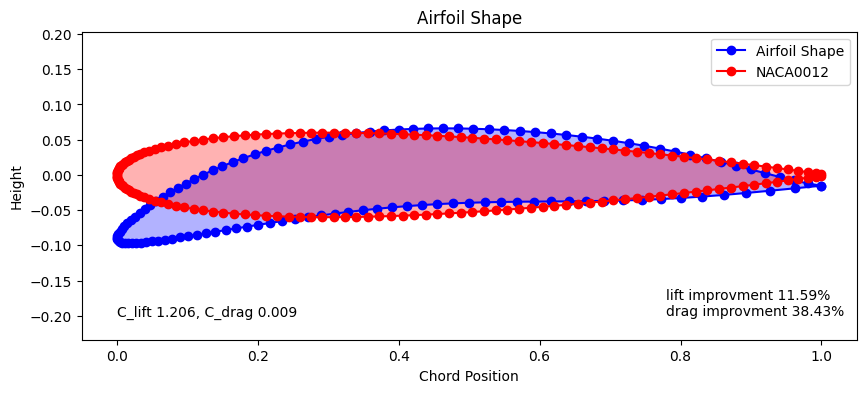

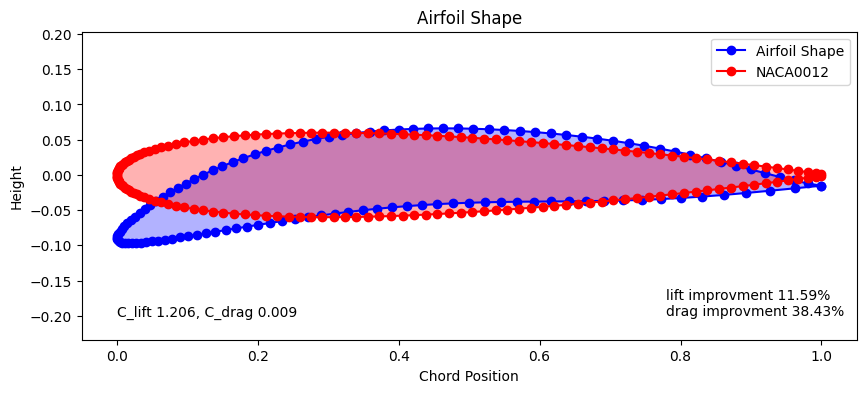

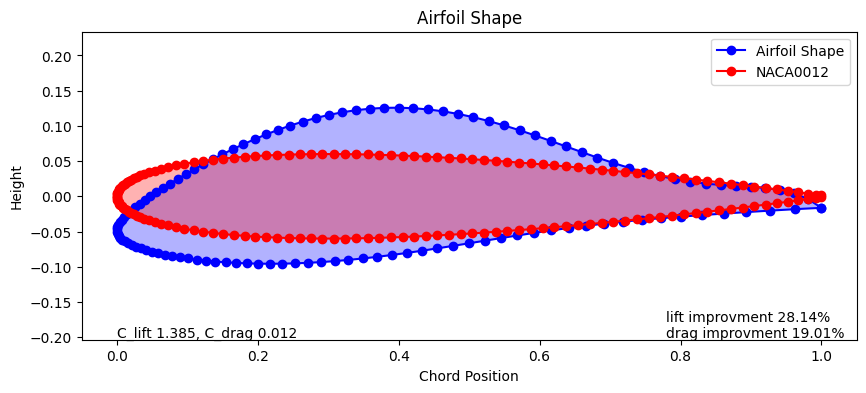

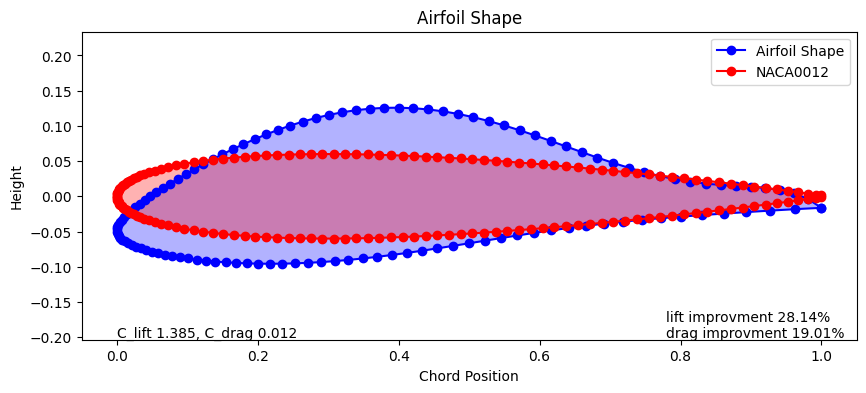

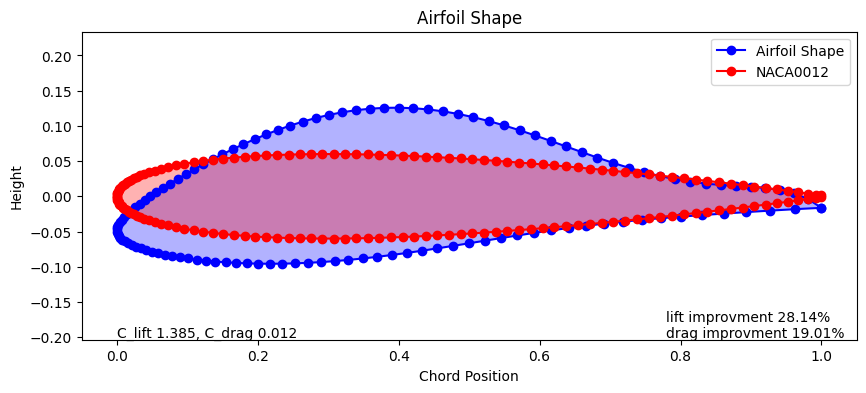

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming naca_eval and other necessary functions are defined elsewhere
naca_a, naca_cl, naca_cd = naca_eval()

for gen, population in populations.items():
    for ind, fit in population:
        if fit[0] != 0 and fit[1] != -1e5:
            if fit[0] in pareto_l:
                best_indiv = np.array([ind[:n_ctr_pts], np.abs(ind[n_ctr_pts:])])
                best, foil = airfoil(best_indiv, n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
                direction = fit[0] / abs(fit[0])
                naca0012_fit = np.array(fitness(naca0012))
                lift_improvement = ((np.abs(fit[0]) - naca0012_fit[0]) / naca0012_fit[0]) * 100
                drag_improvement = ((naca0012_fit[1] - np.abs(fit[1])) / naca0012_fit[1]) * 100
                save = False
                std_points = [naca0012.x, naca0012.y]
                if lift_improvement > 0 and drag_improvement > 0:
                    plot_foil(best, fit, lift_improvement, drag_improvement)



## Section 2

In [14]:
l_p = []
d_p = []
angles = []
naca_a , naca_cl, naca_cd = naca_eval()
for gen, population in populations.items():
    for ind, fit in population:
        if fit[0] != 0 and fit[1] != -1e5:
            if fit[0] in pareto_l:
                best_indiv = np.array([ind[:n_ctr_pts], np.abs(ind[n_ctr_pts:])])
                best, foil = airfoil(best_indiv,  n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
                direction = fit[0] / abs(fit[0])
                naca0012_fit = np.array(fitness(naca0012))
                lift_improvement = ((np.abs(fit[0]) - naca0012_fit[0]) / naca0012_fit[0]) * 100
                drag_improvement = ((naca0012_fit[1] - np.abs(fit[1])) / naca0012_fit[1]) * 100
                #plot_foil(best, fit, lift_improvement, drag_improvement, save=False)
                l_p.append(abs(fit[0]))
                d_p.append(abs(fit[1]))


print(np.mean(np.abs(l_p)), np.mean(np.abs(d_p)))
print(max(l_p), min(np.abs(d_p)))

                


0.9381201410787585 0.030434622965834063
2.1221184730529785 0.005801279563456774
